In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset
import torchmetrics
import numpy as np
import stumpy
from torch.utils.data.dataset import random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as  sns
from matplotlib.patches import Rectangle
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]='1'

### Imports

In [3]:
main_path = Path('/Users/mds8301/Desktop/temp')

In [55]:
full_data = torch.load(main_path/ "dopamine_full_timeseries_array.pt")
# training = torch.load(main_path / 'aa_training.pt')
# testing = torch.load(main_path /'aa_testing.pt')
min_5 = round(full_data.shape[1]/5)

min_5

300693

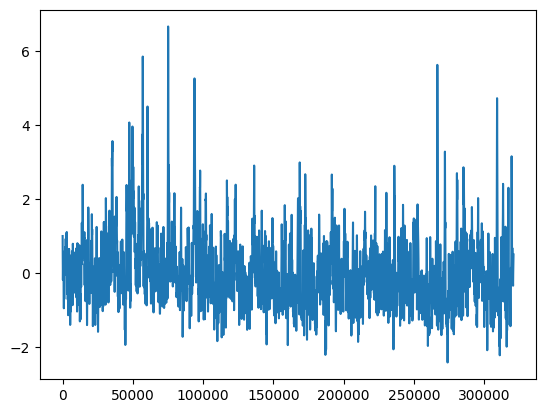

In [5]:


data = full_data[1:][1].detach().numpy().astype(np.float64)[75000:200000]
min_5 = full_data[1:][1].detach().numpy().astype(np.float64)[0:1070*5*60]
min_5_y = full_data[0][0].detach().numpy().astype(np.float64)
m = 1070*2# 5 sec
window = np.arange(m, 1)
window

# min_5_range = 5*60*window
# data_5_min = data[:min_5_range]
fig, ax = plt.subplots()
ax.plot(min_5)

In [6]:
min_5_y

array(1.)

In [7]:
mp = stumpy.stump(data,m , normalize = False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
motif_idx = np.argsort(mp[:, 0])[0] 
motif_idx

94480

In [9]:
nn_1 = mp[motif_idx, 1]
nn_2 = mp[motif_idx, 3]
nn_2


104415

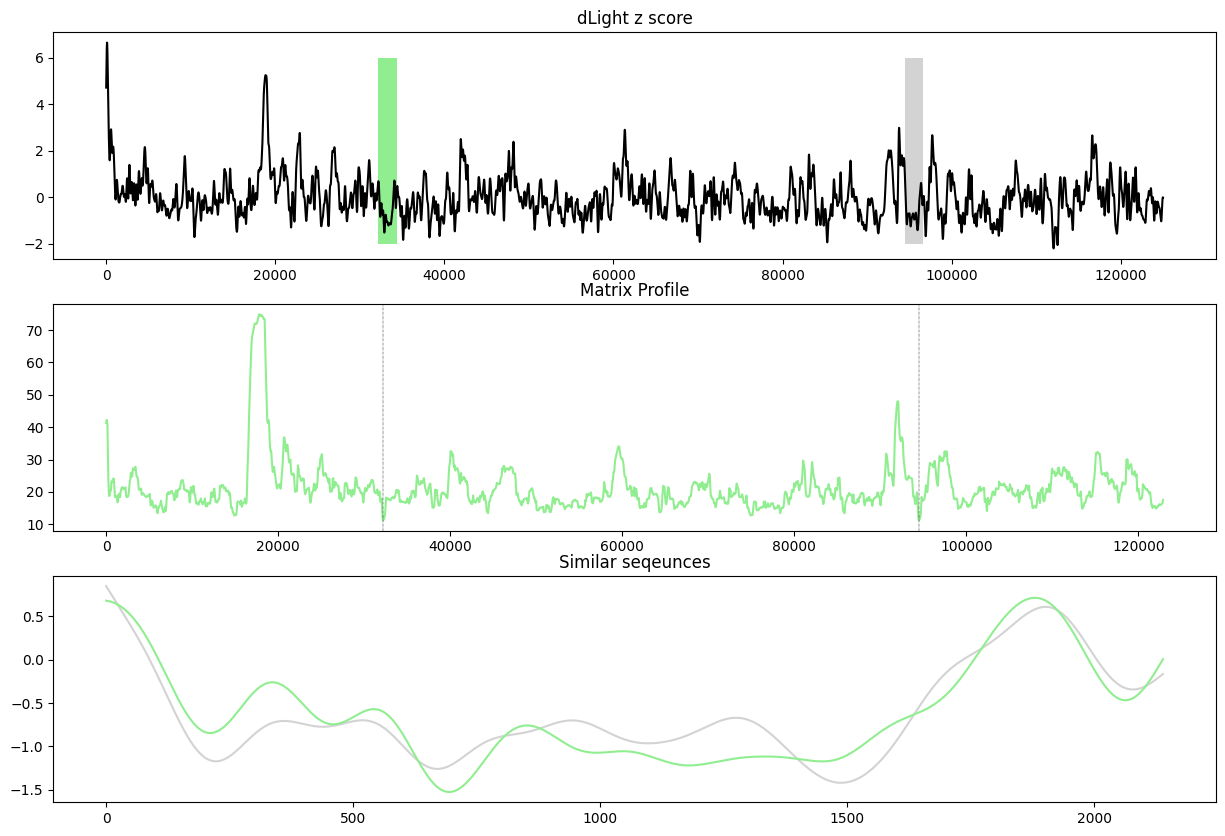

In [10]:

fig, ax = plt.subplots(ncols=1, nrows=3, figsize = (15,10))
ax[0].plot(data, color = 'k')
rect = Rectangle((motif_idx, -2), m, 8, facecolor = 'lightgrey')
ax[0].add_patch(rect)
nn_rect = Rectangle((nn_1, -2), m, 8, facecolor = 'lightgreen')
ax[0].add_patch(nn_rect)
ax[0].set_title('dLight z score')
ax[1].plot(mp[:,0], color='lightgreen')
ax[1].axvline(x = motif_idx, color = 'k', linestyle = '-.', linewidth = .3)
ax[1].set_title('Matrix Profile')
ax[1].axvline(x = nn_1, color = 'k', linestyle = '-.', linewidth = 0.3)
pattern_1 = data[motif_idx: motif_idx+m]
pattern_2 = data[nn_1:nn_1+m]
ax[2].set_title('Similar seqeunces')
ax[2].plot(pattern_1, color='lightgrey')
ax[2].plot(pattern_2, color = 'lightgreen')
# ax[1].axvline(x = nn_2, color = 'k')

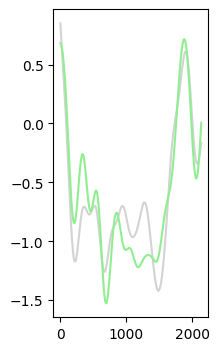

In [11]:
pattern_1 = data[motif_idx: motif_idx+m]
pattern_2 = data[nn_1:nn_1+m]
fig, ax = plt.subplots(ncols = 1, nrows=1, figsize = (2,4))
plt.plot(pattern_1, color='lightgrey')
plt.plot(pattern_2, color='lightgreen')

In [12]:
mp_5_min = stumpy.stump(min_5, m = m)

In [13]:
all_chain_set, unanchored_chain = stumpy.allc(mp_5_min[:, 2], mp_5_min[:, 3])

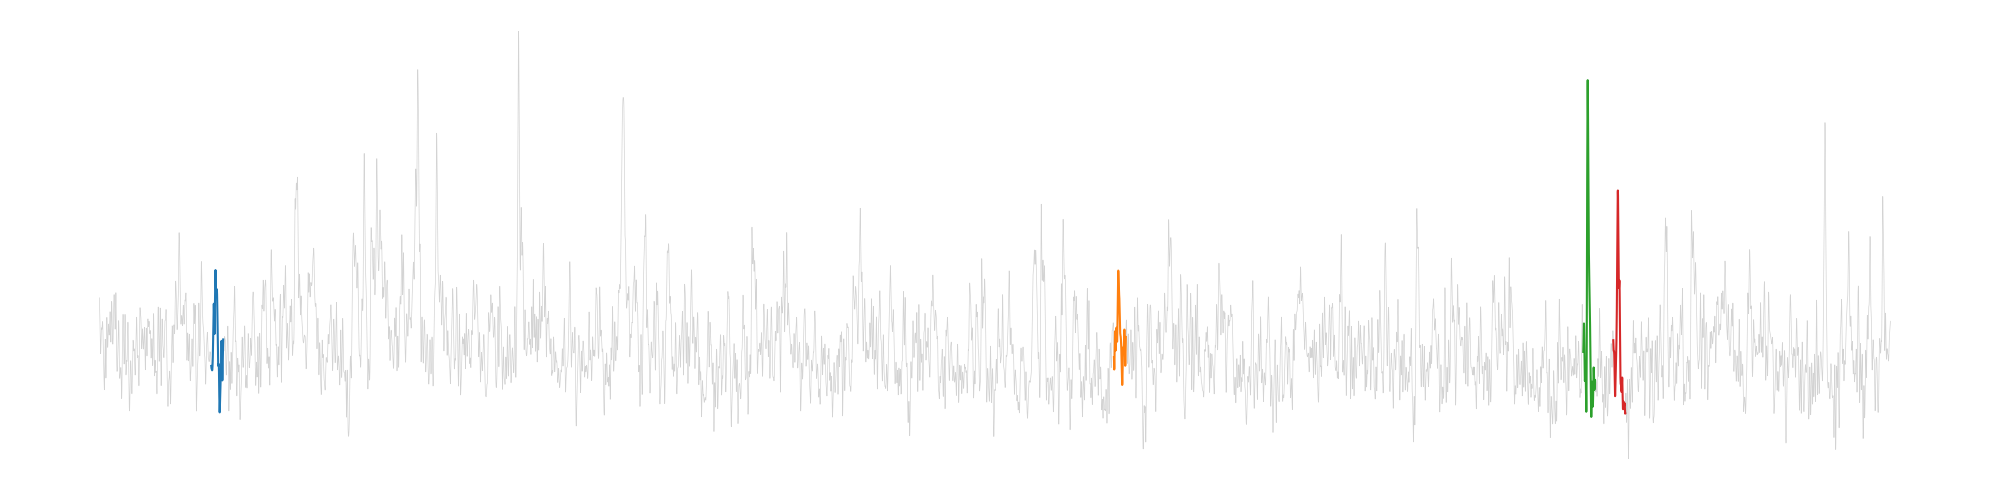

In [14]:

fig, ax = plt.subplots(figsize = (20, 5))
ax.plot(min_5, linewidth = 0.5, color = 'lightgrey')
for i in range(unanchored_chain.shape[0]):
    y = min_5[unanchored_chain[i]: unanchored_chain[i]+m]
    x = np.arange(unanchored_chain[i], unanchored_chain[i]+ m)
    ax.plot(x, y)
    sns.despine(left = True, right = True, bottom=True)
    ax.axis('off')
plt.tight_layout()

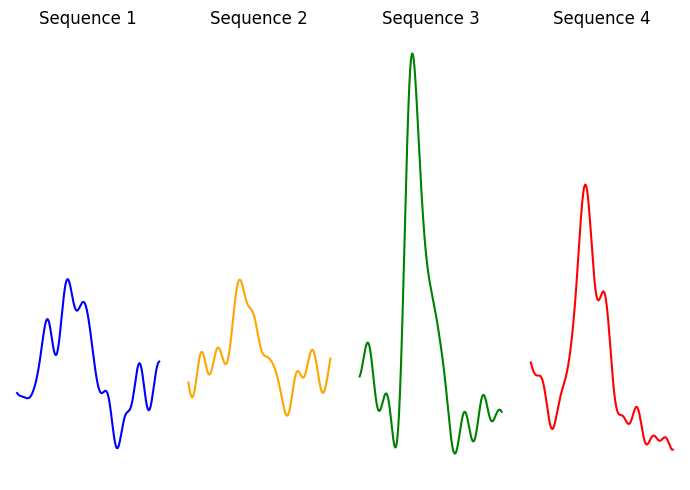

In [15]:

fig, ax = plt.subplots(ncols = 4, figsize = (7, 5))
for i,c in zip(range(unanchored_chain.shape[0]), ['blue', 'orange', 'green', 'red']):
    y = min_5[unanchored_chain[i]: unanchored_chain[i]+m]
    # x = np.arange(unanchored_chain[i], unanchored_chain[i]+ m)
    ax[i].plot(y, color = c)
    ax[i].set_title(f'Sequence {i+1}')
    sns.despine(left = True, right = True, bottom=True)
    
    # set y axis range
    ax[i].set_ylim(-2,6)
    ax[i].axis('off')
plt.tight_layout()

(88, 2000)


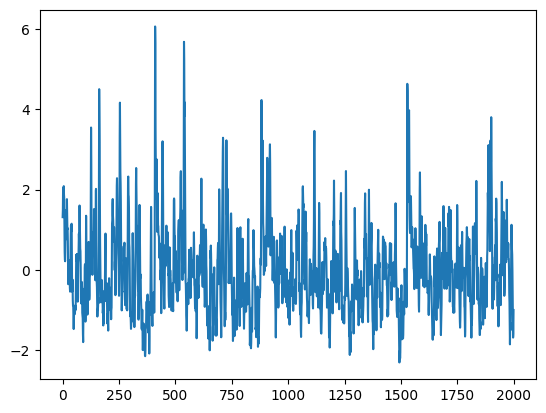

In [94]:
# move tensor to cpu
# full_data = full_data.to('cpu')
np_data= full_data.detach().numpy()[:].astype(np.float64)
np_data = np_data[~np.isnan(np_data[:,0])]
X = np_data[:,1:][:,:][:,:200000][:, ::100]
y = np_data[:,0]
print(X.shape)
plt.plot(X[0])

# Train

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

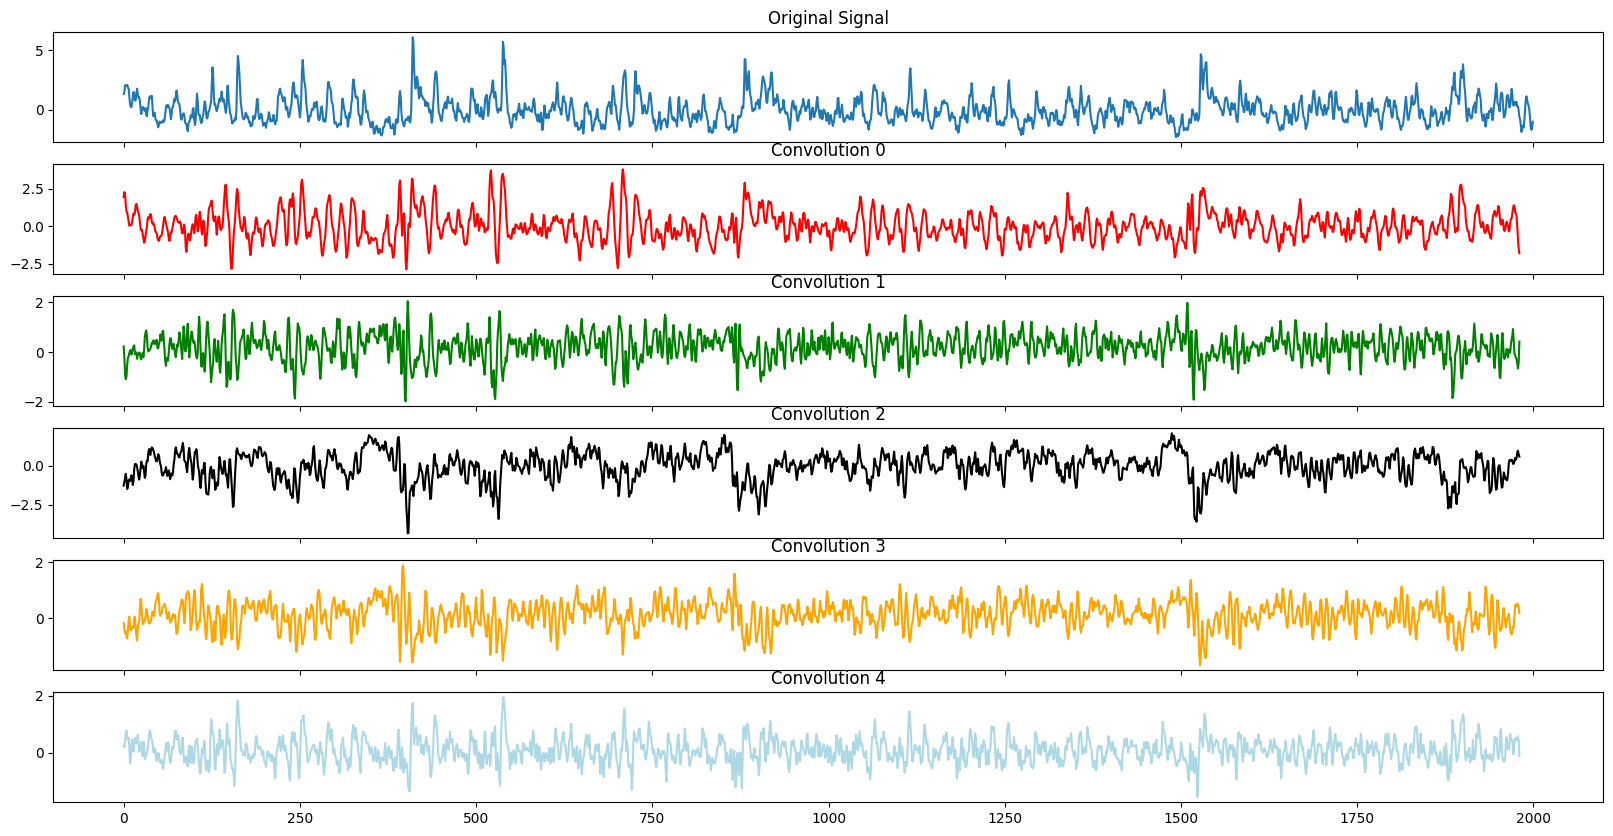

In [95]:
X_tensor = torch.from_numpy(X[0].astype(np.float32)).view(1, -1)
conv1d = nn.Conv1d(1, 5, kernel_size=20)
x_1d = conv1d(X_tensor)
x_1d_arr = x_1d.detach().numpy()
x_1d_arr = x_1d.detach().numpy()
fig, ax = plt.subplots(nrows=x_1d_arr.shape[0]+1, figsize= (20,10), sharex=True)
ax[0].plot(X[0])
ax[0].set_title('Original Signal')
colors = ['red', 'green', 'black', 'orange', 'lightblue']
for i,c in zip(range(x_1d_arr.shape[0]), colors):
    # ax[0].plot(X[0])
    ax[i+1].plot(x_1d_arr[i], color=c)
    ax[i+1].set_title(f"Convolution {i}")

plt.tight_layout

    


In [54]:
min_5 = full_data.detach().numpy().astype(np.float64)[0:1070*5*60]
min_5_clean = min_5[~np.isnan(min_5[:,0])]
min_5_y = min_5_clean[:,0].detach().numpy().astype(np.float64)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [71]:
full_data_clean = full_data[~torch.isnan(full_data[:,0])].detach().numpy().astype(np.float64)[:,::200]
X = full_data_clean[:,1:]
y = full_data_clean[:,0]



array([1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0.])

In [98]:
from sktime.classification.kernel_based import RocketClassifier
clf = RocketClassifier(num_kernels=1000, n_features_per_kernel = 100)
clf.fit(X,y)

RocketClassifier(n_features_per_kernel=100, num_kernels=1000)

In [99]:
y_pred = clf.predict(X)
from sklearn.metrics import accuracy_score, roc_curve
accuracy_score(y, y_pred)

0.9886363636363636

In [96]:
cv = 5
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X, y, cv=cv)

array([0.44444444, 0.5       , 0.83333333, 0.64705882, 0.58823529])

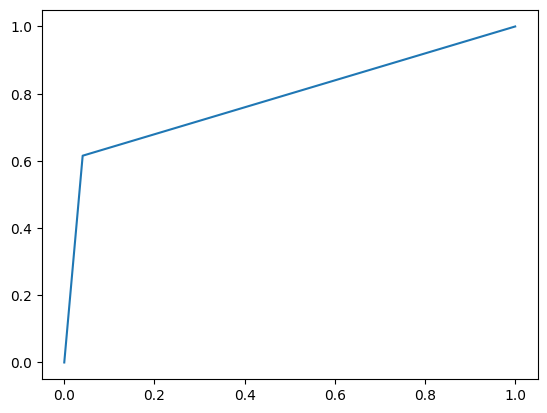